### RAD-DB and Custom datasets with Random Forest (pre-trained model)
- Alternative to CNN for emotion classification
- Calculating additional distance-based features for each emotional class
- Code for webcam footage adapted from https://git.arts.ac.uk/lmccallum/STEM-4-Creatives-22-23/blob/main/STEM-Week-7-Video.ipynb

In [84]:
import os
import numpy as np
import pandas as pd
from ast import literal_eval
import json

# OpenCV and Dlib for image processing
import cv2
import dlib

# Machine Learning libraries
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier, StackingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from scipy.stats import randint
import joblib
import optuna
from optuna.samplers import TPESampler
from sklearn.decomposition import PCA

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Keras for image preprocessing
from tensorflow.keras.preprocessing.image import ImageDataGenerator

### Random Forest on Custom Dataset:

In [17]:
df =pd.read_csv('/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/facial_landmarks_data.csv')

#print(df.head())
# NaN values present, string format, requires removal.
df.dropna(subset=['EyesX', 'EyesY', 'NoseX', 'NoseY', 'MouthX', 'MouthY'], inplace=True)

#eyes_x = df['EyesX'].apply(lambda x: list(map(float, x.strip('[]').split(','))))
#eyes_y = df['EyesY'].apply(lambda x: list(map(float, x.strip('[]').split(','))))

#nose_x = df['NoseX']
#nose_y = df['NoseY']

#mouth_x = df['MouthX'].apply(lambda x: list(map(float, x.strip('[]').split(','))))
#mouth_y = df['MouthY'].apply(lambda x: list(map(float, x.strip('[]').split(','))))

print(df.head())

                               Image  EmotionClass  TotalFaceArea  \
0   pinterest_370491506865098460.png  neutral-face           9801   
1   pinterest_370491506865098460.png  neutral-face          30976   
2  pinterest_1105774514751655987.jpg  neutral-face          47524   
3  pinterest_1105774514751655978.jpg  neutral-face          77284   
4    pinterest_31806741112770968.jpg  neutral-face          16384   

                                               EyesX  \
0  [775, 778, 782, 787, 782, 777, 809, 813, 819, ...   
1  [366, 375, 386, 393, 385, 375, 432, 441, 450, ...   
2  [104, 113, 125, 135, 124, 112, 188, 196, 208, ...   
3  [173, 187, 203, 216, 201, 185, 283, 298, 314, ...   
4  [438, 443, 448, 453, 448, 443, 476, 480, 485, ...   

                                               EyesY  \
0   [51, 49, 49, 52, 53, 53, 53, 51, 51, 53, 55, 55]   
1   [74, 70, 70, 78, 79, 78, 81, 75, 76, 82, 84, 83]   
2  [224, 218, 217, 223, 228, 229, 217, 207, 204, ...   
3  [241, 234, 235, 246, 

In [18]:
# Ensure the columns for landmark data have the correct format for numeric calculations
df['EyesX'] = df['EyesX'].apply(lambda x: list(map(float, x.strip('[]').split(','))))
df['EyesY'] = df['EyesY'].apply(lambda x: list(map(float, x.strip('[]').split(','))))

df['NoseX'] = df['NoseX'].apply(lambda x: list(map(float, x.strip('[]').split(','))))
df['NoseY'] = df['NoseY'].apply(lambda x: list(map(float, x.strip('[]').split(','))))

df['MouthX'] = df['MouthX'].apply(lambda x: list(map(float, x.strip('[]').split(','))))
df['MouthY'] = df['MouthY'].apply(lambda x: list(map(float, x.strip('[]').split(','))))

# Load eyebrow angles that are already in your dataset
df['LeftEyebrowAngle'] = pd.to_numeric(df['LeftEyebrowAngle'], errors='coerce')
df['RightEyebrowAngle'] = pd.to_numeric(df['RightEyebrowAngle'], errors='coerce')


In [24]:
# Calculate the distance between the two eyes
df['EyesDist'] = np.sqrt((df['EyesX'].apply(lambda x: x[0]) - df['EyesX'].apply(lambda x: x[1]))**2 + 
                         (df['EyesY'].apply(lambda x: x[0]) - df['EyesY'].apply(lambda x: x[1]))**2)

# Calculate the average distance between the eyes and the nose
df['EyesToNoseDist'] = np.sqrt((((df['EyesX'].apply(lambda x: np.mean(x))) - df['NoseX'].apply(lambda x: np.mean(x)))**2) + 
                               (((df['EyesY'].apply(lambda x: np.mean(x))) - df['NoseY'].apply(lambda x: np.mean(x)))**2))

# Calculate the distance from the nose to the mouth
df['NoseToMouthDist'] = np.sqrt((df['NoseX'].apply(lambda x: np.mean(x)) - df['MouthX'].apply(lambda x: np.mean(x)))**2 + 
                                (df['NoseY'].apply(lambda x: np.mean(x)) - df['MouthY'].apply(lambda x: np.mean(x)))**2)

# Calculate mouth angle (between left and right mouth corners)
df['MouthAngle'] = np.degrees(np.arctan2(df['MouthY'].apply(lambda x: x[0] - x[1]), 
                                         df['MouthX'].apply(lambda x: x[0] - x[1])))

# Calculate the nose angle (relative to the eye line)
df['NoseAngle'] = np.degrees(np.arctan2(df['NoseY'].apply(lambda x: np.mean(x)) - df['EyesY'].apply(lambda x: np.mean(x)), 
                                        df['NoseX'].apply(lambda x: np.mean(x)) - df['EyesX'].apply(lambda x: np.mean(x))))


In [27]:
features = ['EyesDist', 'EyesToNoseDist', 'NoseToMouthDist', 'MouthAngle', 'NoseAngle', 
            'LeftEyebrowAngle', 'RightEyebrowAngle']

X = df[features]
y = df['EmotionClass']  # Emotion class will be your target variable for classification

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Evaluate the model
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.5519677093844602
Confusion Matrix:
 [[101  56  45  30]
 [ 31 174  41  15]
 [ 32  61 214  23]
 [ 25  49  36  58]]


In [29]:
# Save data to csv sheet
df.to_csv('facial_landmarks_dataversion2.csv', index=False)


Visualising the relationships between facial features and emotions



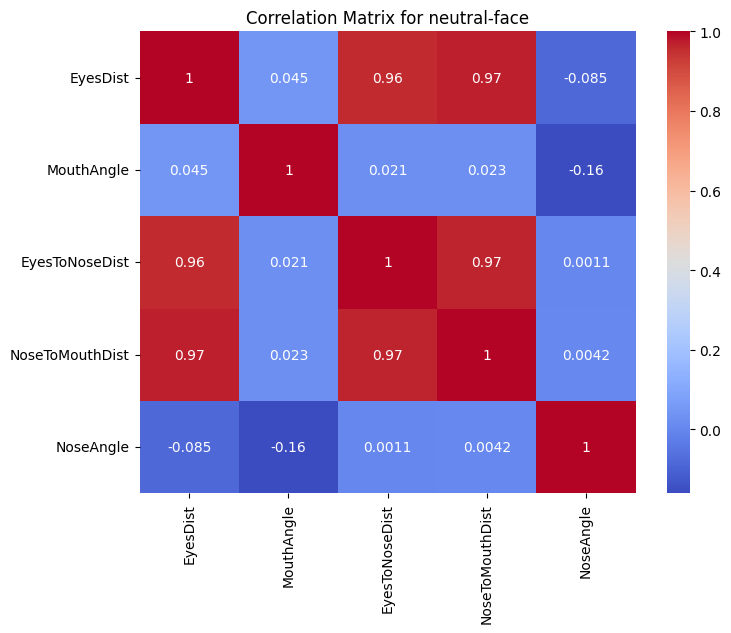

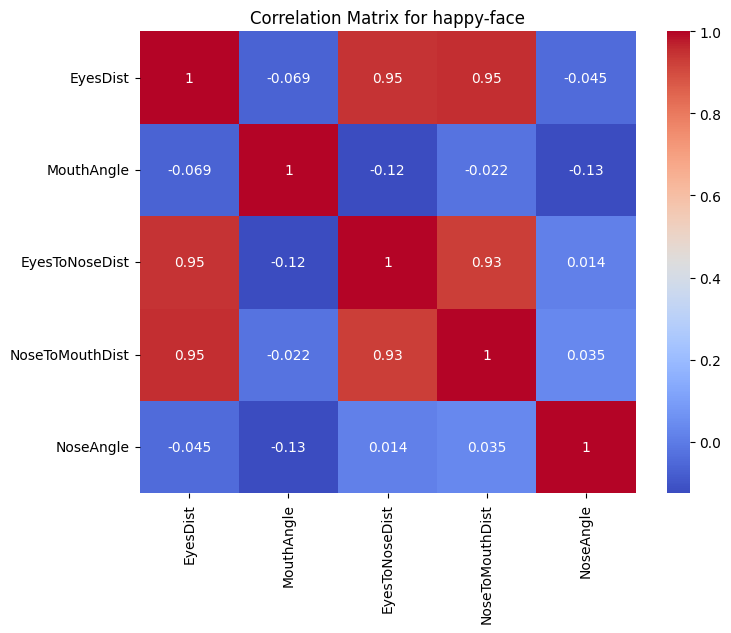

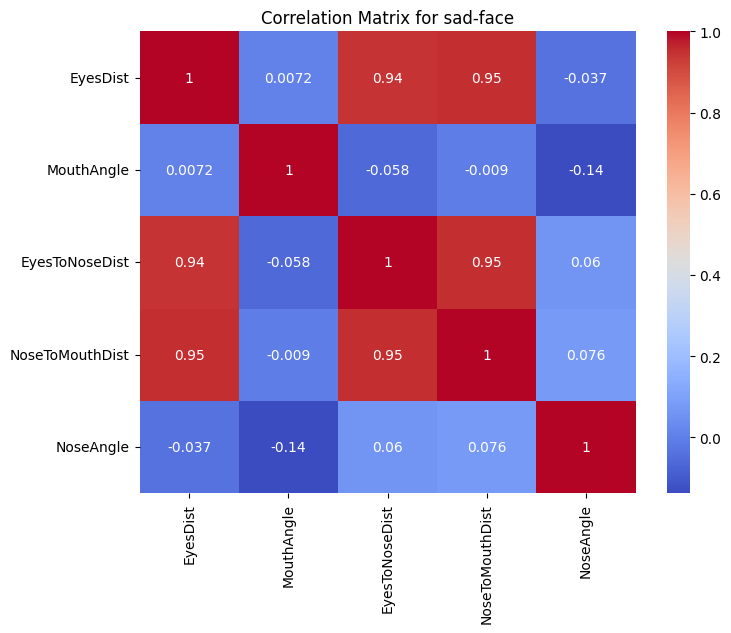

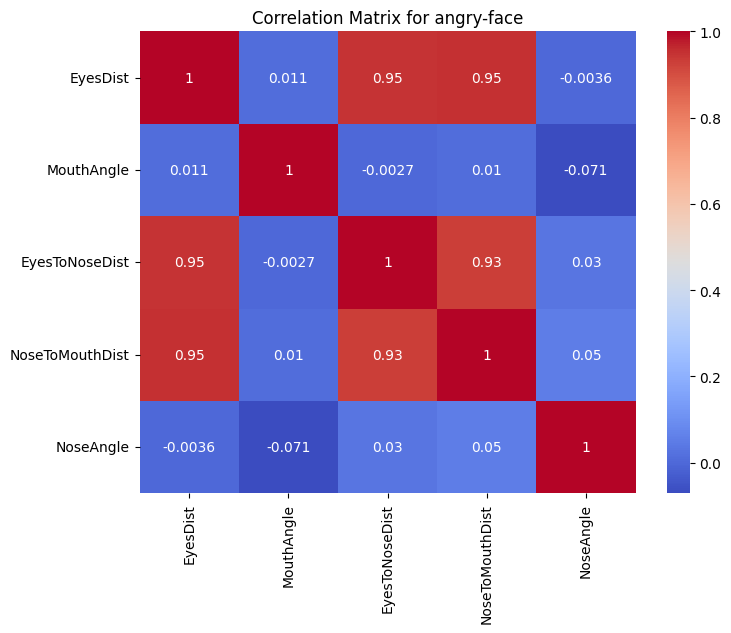

Data ranges for neutral-face:
          EyesDist   MouthAngle  EyesToNoseDist  NoseToMouthDist    NoseAngle
count  1564.000000  1564.000000     1564.000000      1564.000000  1564.000000
mean     15.114452   141.879141       53.653578        64.582774    93.324608
std      12.185767    49.623923       44.192728        52.767851    10.088995
min       1.414214  -176.820170        5.877364         6.679306    51.172622
25%       5.830952   138.366461       20.739314        25.519739    89.260299
50%      12.727922   149.931417       40.607303        48.416697    93.195834
75%      20.826642   161.565051       75.128282        89.114836    97.746122
max     110.860272   180.000000      431.569578       514.638949   134.827941


Data ranges for happy-face:
          EyesDist   MouthAngle  EyesToNoseDist  NoseToMouthDist    NoseAngle
count  1345.000000  1345.000000     1345.000000      1345.000000  1345.000000
mean     11.854409   122.030739       39.240060        49.719367    93.445304
std 

In [31]:
# Analyze the correlations between facial landmark data and emotional classes (sad, angry, happy, neutral)

# Load facial_landmarks_dataversion2.csv
df = pd.read_csv('/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/facial_landmarks_dataversion2.csv')
# Define the features to analyze
features = ['EyesDist', 'MouthAngle', 'EyesToNoseDist', 'NoseToMouthDist', 'NoseAngle']

# Calculate correlation matrices for each emotional class
emotions = df['EmotionClass'].unique()
correlation_matrices = {}

for emotion in emotions:
    subset = df[df['EmotionClass'] == emotion]
    corr_matrix = subset[features].corr()
    correlation_matrices[emotion] = corr_matrix

# Plot correlation matrices for each emotional class
for emotion, corr_matrix in correlation_matrices.items():
    plt.figure(figsize=(8, 6))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
    plt.title(f'Correlation Matrix for {emotion}')
    plt.show()

# Analyze data ranges for each feature within each emotional class
data_ranges = {}

for emotion in emotions:
    subset = df[df['EmotionClass'] == emotion]
    data_ranges[emotion] = subset[features].describe()

# Print data ranges for each emotional class
for emotion, stats in data_ranges.items():
    print(f"Data ranges for {emotion}:")
    print(stats)
    print("\n")

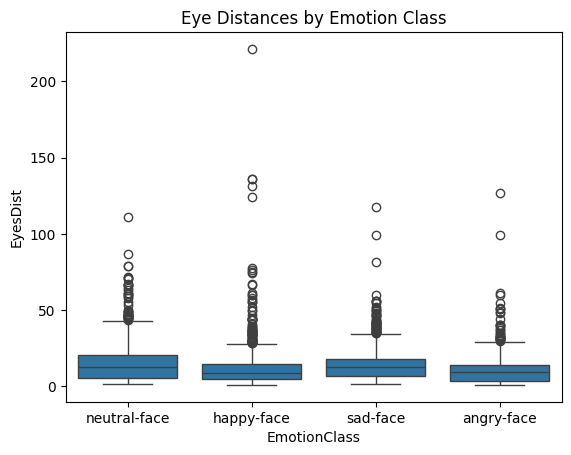

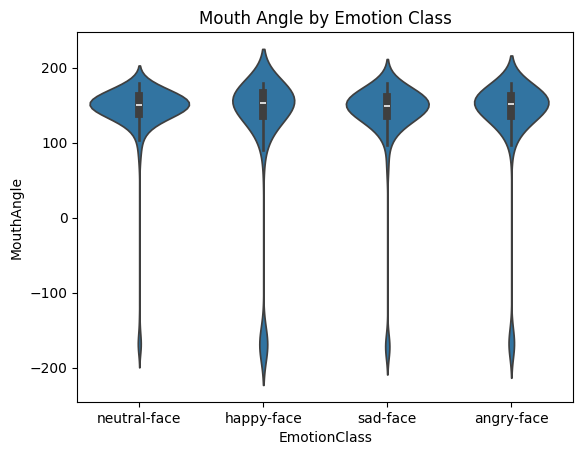

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

#df = pd.read_csv('cleaned_facial_landmarks_data.csv')

sns.boxplot(x='EmotionClass', y='EyesDist', data=df)
plt.title('Eye Distances by Emotion Class')
plt.show()

# Violin plot of Mouth Angle by Emotion Class
sns.violinplot(x='EmotionClass', y='MouthAngle', data=df)
plt.title('Mouth Angle by Emotion Class')
plt.show()

Key observations: (boxplot)
- Neutral-Face: The eye distance is centered around a median of about 15 units, with a few significant outliers reaching above 100. Most data points cluster below 50.
- Happy-Face: The distribution is similar to neutral-face, though it appears slightly more spread out, with fewer outliers at the high end.
- Sad-Face: The distribution has a higher density around lower values, with a smaller range of outliers compared to other emotions.
- Angry-Face: This distribution is also compressed towards the lower end, but with a few more pronounced outliers similar to neutral-face.

key observations: (violin plot)
- Neutral-Face: The mouth angles are mostly clustered around a central value of around 140–160 degrees, but there are also significant data points around the extremes of -200 to +200 degrees.
- Happy-Face: The mouth angles are mostly positive, with some outliers below zero. The density of angles between 135 to 180 degrees likely corresponds to smiling faces.
- Sad-Face: Similar to neutral, but with more evenly distributed negative and positive values, indicating variation between smiles and frowns.
- Angry-Face: Similar to sad-face, though with slightly higher density in the negative angle range.
Overall, the outh angles had a distinct pattern for happy faces whereas other emotions had higher variabilities. This likely reflects smiling versus neural or frowning expressions.


### Normalization and statistics

In [32]:
# Load your CSV file
df = pd.read_csv('/Users/nixi/Desktop/Final-thesis-folder-24/AI-for-Media-project-23-24/facial_landmarks_dataversion2.csv')

# Convert string representations of lists into actual lists
for col in ['EyesX', 'EyesY', 'NoseX', 'NoseY', 'MouthX', 'MouthY']:
    df[col] = df[col].apply(lambda x: literal_eval(x) if isinstance(x, str) else np.nan)

# Compute the mean of the lists
for col in ['EyesX', 'EyesY', 'NoseX', 'NoseY', 'MouthX', 'MouthY']:
    df[f'{col}_mean'] = df[col].apply(lambda x: np.mean(x) if isinstance(x, list) else np.nan)

# Convert TotalFaceArea to numeric and drop rows with NaN values
df['TotalFaceArea'] = pd.to_numeric(df['TotalFaceArea'], errors='coerce')
necessary_columns = ['EmotionClass', 'TotalFaceArea'] + [f'{col}_mean' for col in ['EyesX', 'EyesY', 'NoseX', 'NoseY', 'MouthX', 'MouthY']]
df = df.dropna(subset=necessary_columns)

# Calculate distances
df['EyeToNose'] = np.sqrt((df['EyesX_mean'] - df['NoseX_mean'])**2 + (df['EyesY_mean'] - df['NoseY_mean'])**2)
df['EyeToMouth'] = np.sqrt((df['EyesX_mean'] - df['MouthX_mean'])**2 + (df['EyesY_mean'] - df['MouthY_mean'])**2)
df['NoseToMouth'] = np.sqrt((df['NoseX_mean'] - df['MouthX_mean'])**2 + (df['NoseY_mean'] - df['MouthY_mean'])**2)
df['EyeAspectRatio'] = np.abs(df['EyesX_mean'] - df['MouthX_mean']) / np.abs(df['EyesY_mean'] - df['MouthY_mean'])

# Normalize features by TotalFaceArea
df['EyeToNose_normalized'] = df['EyeToNose'] / df['TotalFaceArea']
df['EyeToMouth_normalized'] = df['EyeToMouth'] / df['TotalFaceArea']
df['NoseToMouth_normalized'] = df['NoseToMouth'] / df['TotalFaceArea']
df['EyeAspectRatio_normalized'] = df['EyeAspectRatio'] / df['TotalFaceArea']

# Select features for the model
features = ['EyeToNose_normalized', 'EyeToMouth_normalized', 'NoseToMouth_normalized', 'EyeAspectRatio_normalized']
X = df[features]
y = df['EmotionClass']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_scaled, y_train)

# Make predictions and evaluate
y_pred = rf_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))

# Print feature importances
for feature, importance in zip(features, rf_model.feature_importances_):
    print(f"{feature}: {importance}")


              precision    recall  f1-score   support

  angry-face       0.40      0.41      0.41       232
  happy-face       0.42      0.42      0.42       261
neutral-face       0.54      0.57      0.55       330
    sad-face       0.33      0.27      0.30       168

    accuracy                           0.44       991
   macro avg       0.42      0.42      0.42       991
weighted avg       0.44      0.44      0.44       991

EyeToNose_normalized: 0.24380796523089057
EyeToMouth_normalized: 0.24854321989554592
NoseToMouth_normalized: 0.2581824434627366
EyeAspectRatio_normalized: 0.24946637141082692


/var/folders/1t/ywcqy6hd69g8pdsvmwf99pwh0000gn/T/ipykernel_40696/3988776686.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='EmotionClass', y='Number of Images', data=class_counts, palette='viridis')


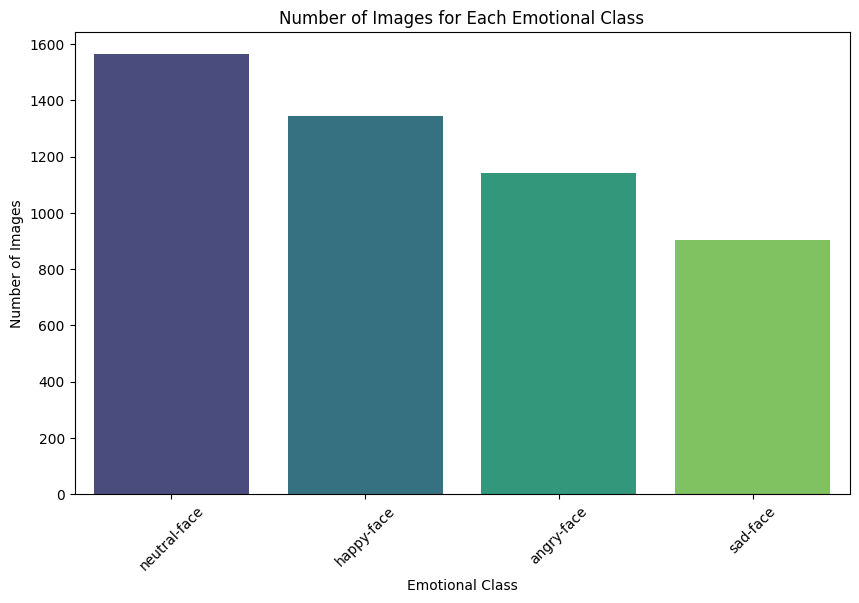

In [40]:
df = pd.read_csv('facial_landmarks_dataversion2.csv')

# Count the number of images for each emotional class
class_counts = df['EmotionClass'].value_counts().reset_index()
class_counts.columns = ['EmotionClass', 'Number of Images']

color_mapping = dict(zip(emotions, colors))
# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='EmotionClass', y='Number of Images', data=class_counts, palette='viridis')
plt.title('Number of Images for Each Emotional Class')
plt.xlabel('Emotional Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()


In [58]:
# Exclude 'Image' and 'EmotionClass' columns before scaling
# Exclude 'Image' and 'EmotionClass' columns before scaling
numeric_columns = df.select_dtypes(include=[np.number]).columns
columns_to_exclude = ['EmotionClass', 'Image']
columns_to_drop = [col for col in columns_to_exclude if col in numeric_columns]
X = df[numeric_columns].drop(columns=columns_to_drop)

y = df['EmotionClass']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save the scaler to a file
joblib.dump(scaler, 'scaler.pkl')

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier()

# Train the classifier
rf_classifier.fit(X_train_scaled, y_train)

# Predict on the test set
predictions = rf_classifier.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions, output_dict=True)


# Evaluate the model
print(classification_report(y_test, predictions))

# Save the evaluation results to a file
evaluation_results = {
    'accuracy': accuracy,
    'classification_report': report
}

with open('random_forest_evaluation.json', 'w') as f:
    json.dump(evaluation_results, f, indent=4)

# Save the model
joblib.dump(rf_classifier, 'random_forest_model.pkl')  # Save model

              precision    recall  f1-score   support

  angry-face       0.59      0.50      0.54       232
  happy-face       0.50      0.65      0.57       261
neutral-face       0.61      0.64      0.62       330
    sad-face       0.47      0.31      0.37       168

    accuracy                           0.55       991
   macro avg       0.54      0.53      0.53       991
weighted avg       0.55      0.55      0.55       991



['random_forest_model.pkl']

In [61]:
numeric_columns = df.select_dtypes(include=[np.number]).columns
columns_to_exclude = ['EmotionClass', 'Image']
columns_to_drop = [col for col in columns_to_exclude if col in numeric_columns]
X = df[numeric_columns].drop(columns=columns_to_drop)

y = df['EmotionClass']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Save the scaler to a file
joblib.dump(scaler, 'scaler.pkl')

# Define the parameter grid for Grid Search. Code adapted from : https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier()

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2) # code adapted from: https://medium.com/@Doug-Creates/tuning-random-forest-parameters-with-scikit-learn-b53cbc602cd0
grid_search.fit(X_train_scaled, y_train)

# Get the best estimator
best_rf_classifier = grid_search.best_estimator_

# Train the best estimator
best_rf_classifier.fit(X_train_scaled, y_train)

# Predict on the test set
predictions = best_rf_classifier.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
report = classification_report(y_test, predictions, output_dict=True)

# Print the classification report
print(classification_report(y_test, predictions))

# Save the evaluation results to a file
evaluation_results = {
    'accuracy': accuracy,
    'classification_report': report
}

with open('random_forest_evaluation.json', 'w') as f:
    json.dump(evaluation_results, f, indent=4)

# Save the best model
joblib.dump(best_rf_classifier, 'random_forest_model.pkl')

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.7s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.8s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.9s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.3s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   3.4s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; tot

['random_forest_model.pkl']

In [87]:
# Assuming X_train contains the features used during training
print(f"Training features shape: {X_train.shape}")
print(f"Training features: {X_train.columns if isinstance(X_train, pd.DataFrame) else 'Not a DataFrame'}")


Training features shape: (3961, 9)
Training features: Index(['TotalFaceArea', 'LeftEyebrowAngle', 'RightEyebrowAngle',
       'EyebrowDistance', 'EyesDist', 'EyesToNoseDist', 'NoseToMouthDist',
       'MouthAngle', 'NoseAngle'],
      dtype='object')


Random Forest with Bayesian Optimization for Hyperparameter Tuning:

In [82]:
# updated code using SMOTE which oversamples the minority classes and GridSearchCV to find the best hyperparameters for the overall random_forest_model.pkl model
numeric_columns = df.select_dtypes(include=[np.number]).columns
columns_to_exclude = ['EmotionClass', 'Image']
columns_to_drop = [col for col in columns_to_exclude if col in numeric_columns]
X = df[numeric_columns].drop(columns=columns_to_drop)

y = df['EmotionClass']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Save the scaler to a file
joblib.dump(scaler, 'scaler.pkl')

# Define the parameter distribution for Randomized Search
param_dist = {
    'n_estimators': randint(100, 1000),
    'max_depth': [None] + list(np.arange(10, 50, 10)),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'bootstrap': [True, False],
    'class_weight': ['balanced', 'balanced_subsample', 
                     {'angry-face': 1, 'happy-face': 1, 'neutral-face': 1, 'sad-face': 2}, 
                     {'angry-face': 1, 'happy-face': 2, 'neutral-face': 1, 'sad-face': 2}]
}

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Perform Randomized Search with cross-validation
random_search = RandomizedSearchCV(estimator=rf_classifier, param_distributions=param_dist, n_iter=200, cv=5, n_jobs=-1, verbose=2, random_state=42)
random_search.fit(X_train_scaled, y_train_resampled)

# Get the best estimator
best_rf_classifier = random_search.best_estimator_

# Train the best estimator
best_rf_classifier.fit(X_train_scaled, y_train_resampled)

# Predict on the test set
predictions_rf = best_rf_classifier.predict(X_test_scaled)

# Evaluate the Random Forest model
accuracy_rf = accuracy_score(y_test, predictions_rf)
report_rf = classification_report(y_test, predictions_rf, output_dict=True)

# Print the classification report for Random Forest
print("Random Forest Classification Report:")
print(classification_report(y_test, predictions_rf))

# Analyze misclassifications
conf_matrix = confusion_matrix(y_test, predictions_rf)
print("Confusion Matrix:")
print(conf_matrix)

# Save the evaluation results to a file
evaluation_results = {
    'accuracy_rf': accuracy_rf,
    'classification_report_rf': report_rf,
    'confusion_matrix': conf_matrix.tolist()
}

with open('random_forest_evaluation.json', 'w') as f:
    json.dump(evaluation_results, f, indent=4)

# Save the best model
joblib.dump(best_rf_classifier, 'random_forest_model.pkl')

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV] END bootstrap=True, class_weight={'angry-face': 1, 'happy-face': 2, 'neutral-face': 1, 'sad-face': 2}, max_depth=40, min_samples_leaf=15, min_samples_split=12, n_estimators=171; total time=   1.4s
[CV] END bootstrap=True, class_weight={'angry-face': 1, 'happy-face': 2, 'neutral-face': 1, 'sad-face': 2}, max_depth=40, min_samples_leaf=15, min_samples_split=12, n_estimators=171; total time=   1.5s
[CV] END bootstrap=True, class_weight={'angry-face': 1, 'happy-face': 2, 'neutral-face': 1, 'sad-face': 2}, max_depth=40, min_samples_leaf=15, min_samples_split=12, n_estimators=171; total time=   1.5s
[CV] END bootstrap=True, class_weight={'angry-face': 1, 'happy-face': 2, 'neutral-face': 1, 'sad-face': 2}, max_depth=40, min_samples_leaf=15, min_samples_split=12, n_estimators=171; total time=   1.6s
[CV] END bootstrap=True, class_weight={'angry-face': 1, 'happy-face': 2, 'neutral-face': 1, 'sad-face': 2}, max_depth=40, min_sa

['random_forest_model.pkl']

In [85]:
# with ensembe models
numeric_columns = df.select_dtypes(include=[np.number]).columns
columns_to_exclude = ['EmotionClass', 'Image']
columns_to_drop = [col for col in columns_to_exclude if col in numeric_columns]
X = df[numeric_columns].drop(columns=columns_to_drop)

y = df['EmotionClass']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Handle class imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_resampled)
X_test_scaled = scaler.transform(X_test)

# Save the scaler to a file
joblib.dump(scaler, 'scaler.pkl')

# Define the parameter distribution for Randomized Search
param_dist = {
    'n_estimators': randint(100, 1000),
    'max_depth': [None] + list(np.arange(10, 50, 10)),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'bootstrap': [True, False],
    'class_weight': ['balanced', 'balanced_subsample', 
                     {'angry-face': 1, 'happy-face': 1, 'neutral-face': 1, 'sad-face': 2}, 
                     {'angry-face': 1, 'happy-face': 2, 'neutral-face': 1, 'sad-face': 2}]
}

# Create a Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Perform Randomized Search with cross-validation
random_search = RandomizedSearchCV(estimator=rf_classifier, param_distributions=param_dist, n_iter=200, cv=5, n_jobs=-1, verbose=2, random_state=42)
random_search.fit(X_train_scaled, y_train_resampled)

# Get the best estimator
best_rf_classifier = random_search.best_estimator_

# Train the best estimator
best_rf_classifier.fit(X_train_scaled, y_train_resampled)

# Predict on the test set
predictions_rf = best_rf_classifier.predict(X_test_scaled)

# Evaluate the Random Forest model
accuracy_rf = accuracy_score(y_test, predictions_rf)
report_rf = classification_report(y_test, predictions_rf, output_dict=True)

# Print the classification report for Random Forest
print("Random Forest Classification Report:")
print(classification_report(y_test, predictions_rf))

# Feature importance
feature_importances = best_rf_classifier.feature_importances_
feature_names = X.columns

# Create a DataFrame for feature importances
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print the top 10 most important features
print("Top 10 Feature Importances:")
print(importance_df.head(10))

# Create a Gradient Boosting classifier
gb_classifier = GradientBoostingClassifier(random_state=42)

# Train the Gradient Boosting classifier
gb_classifier.fit(X_train_scaled, y_train_resampled)

# Predict on the test set
predictions_gb = gb_classifier.predict(X_test_scaled)

# Evaluate the Gradient Boosting model
accuracy_gb = accuracy_score(y_test, predictions_gb)
report_gb = classification_report(y_test, predictions_gb, output_dict=True)

# Print the classification report for Gradient Boosting
print("Gradient Boosting Classification Report:")
print(classification_report(y_test, predictions_gb))

# Create a stacking ensemble model
estimators = [
    ('rf', best_rf_classifier),
    ('gb', gb_classifier)
]

stacking_classifier = StackingClassifier(estimators=estimators, final_estimator=RandomForestClassifier(random_state=42))

# Train the stacking ensemble model
stacking_classifier.fit(X_train_scaled, y_train_resampled)

# Predict on the test set
predictions_stacking = stacking_classifier.predict(X_test_scaled)

# Evaluate the stacking ensemble model
accuracy_stacking = accuracy_score(y_test, predictions_stacking)
report_stacking = classification_report(y_test, predictions_stacking, output_dict=True)

# Print the classification report for the stacking ensemble model
print("Stacking Ensemble Model Classification Report:")
print(classification_report(y_test, predictions_stacking))

# Analyze misclassifications
conf_matrix = confusion_matrix(y_test, predictions_stacking)
print("Confusion Matrix:")
print(conf_matrix)

# Save the evaluation results to a file
evaluation_results = {
    'accuracy_rf': accuracy_rf,
    'classification_report_rf': report_rf,
    'accuracy_gb': accuracy_gb,
    'classification_report_gb': report_gb,
    'accuracy_stacking': accuracy_stacking,
    'classification_report_stacking': report_stacking,
    'confusion_matrix': conf_matrix.tolist()
}

with open('model_evaluation.json', 'w') as f:
    json.dump(evaluation_results, f, indent=4)

# Save the best models
joblib.dump(best_rf_classifier, 'random_forest_model.pkl')
joblib.dump(gb_classifier, 'gradient_boosting_model.pkl')
joblib.dump(stacking_classifier, 'stacking_model.pkl')

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
[CV] END bootstrap=True, class_weight={'angry-face': 1, 'happy-face': 2, 'neutral-face': 1, 'sad-face': 2}, max_depth=40, min_samples_leaf=15, min_samples_split=12, n_estimators=171; total time=   1.6s
[CV] END bootstrap=True, class_weight={'angry-face': 1, 'happy-face': 2, 'neutral-face': 1, 'sad-face': 2}, max_depth=40, min_samples_leaf=15, min_samples_split=12, n_estimators=171; total time=   1.6s
[CV] END bootstrap=True, class_weight={'angry-face': 1, 'happy-face': 2, 'neutral-face': 1, 'sad-face': 2}, max_depth=40, min_samples_leaf=15, min_samples_split=12, n_estimators=171; total time=   1.7s
[CV] END bootstrap=True, class_weight={'angry-face': 1, 'happy-face': 2, 'neutral-face': 1, 'sad-face': 2}, max_depth=40, min_samples_leaf=15, min_samples_split=12, n_estimators=171; total time=   1.7s
[CV] END bootstrap=True, class_weight={'angry-face': 1, 'happy-face': 2, 'neutral-face': 1, 'sad-face': 2}, max_depth=40, min_sa

['stacking_model.pkl']

### RAF-DB dataset and Random Forest (pre-trained model)

[ WARN:0@12170.783] global loadsave.cpp:241 findDecoder imread_('/Users/nixi/Desktop/Final-thesis-folder-24/rafdb_basic/Image/original/test_0284.jpg'): can't open/read file: check file path/integrity
[ WARN:0@12170.783] global loadsave.cpp:241 findDecoder imread_('/Users/nixi/Desktop/Final-thesis-folder-24/rafdb_basic/Image/original/test_0286.jpg'): can't open/read file: check file path/integrity
[ WARN:0@12170.785] global loadsave.cpp:241 findDecoder imread_('/Users/nixi/Desktop/Final-thesis-folder-24/rafdb_basic/Image/original/test_0290.jpg'): can't open/read file: check file path/integrity
[ WARN:0@12170.787] global loadsave.cpp:241 findDecoder imread_('/Users/nixi/Desktop/Final-thesis-folder-24/rafdb_basic/Image/original/test_0294.jpg'): can't open/read file: check file path/integrity
[ WARN:0@12170.788] global loadsave.cpp:241 findDecoder imread_('/Users/nixi/Desktop/Final-thesis-folder-24/rafdb_basic/Image/original/test_0296.jpg'): can't open/read file: check file path/integrity


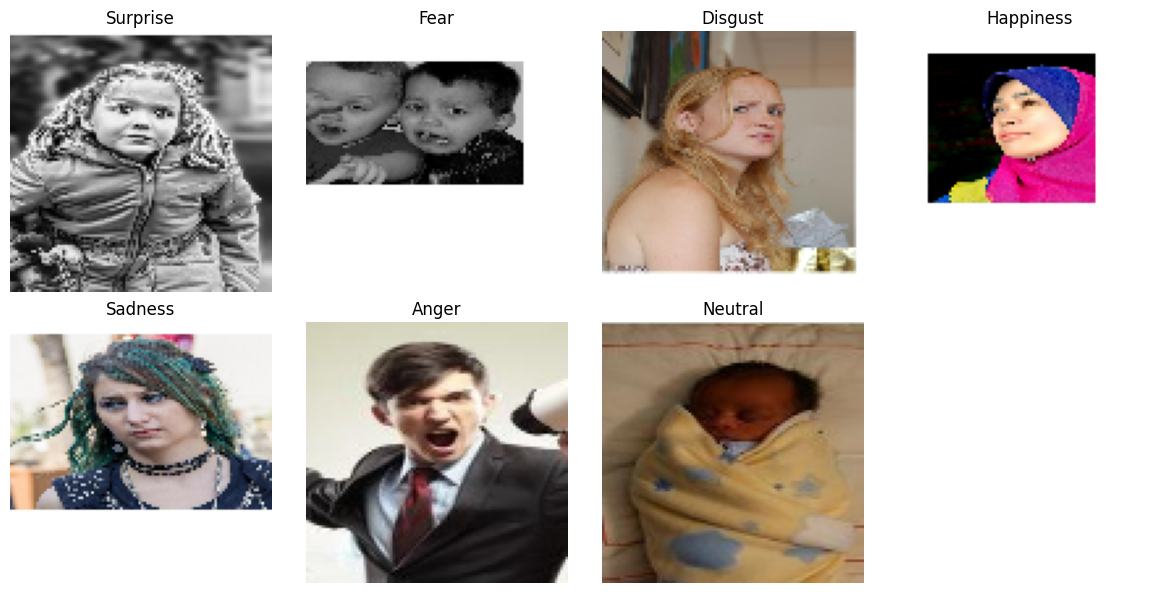

In [43]:
# Paths to dataset and labels
dataset_path = '/Users/nixi/Desktop/Final-thesis-folder-24/rafdb_basic'
images_path = os.path.join(dataset_path, 'Image/original')
labels_path = os.path.join(dataset_path, 'EmoLabel/list_patition_label.txt')

# Initialize a dictionary to hold sample images for each class
sample_images = {1: None, 2: None, 3: None, 4: None, 5: None, 6: None, 7: None}

# Define emotional class names
emotional_classes = {
    1: 'Surprise',
    2: 'Fear',
    3: 'Disgust',
    4: 'Happiness',
    5: 'Sadness',
    6: 'Anger',
    7: 'Neutral'
}

# Load labels and find sample images
with open(labels_path, 'r') as f:
    for line in f:
        img_name, label = line.strip().split(' ')
        label = int(label)

        # Load the image
        img_path = os.path.join(images_path, img_name)
        img = cv2.imread(img_path)

        # Check if the image was loaded successfully and if we haven't already found a sample for this label
        if img is not None and sample_images[label] is None:
            # Resize the image for better display
            img_resized = cv2.resize(img, (100, 100))  # Resize to 100x100 for display
            sample_images[label] = img_resized

# Plot the sample images
plt.figure(figsize=(12, 6))
for i, (label, img) in enumerate(sample_images.items()):
    plt.subplot(2, 4, i + 1)  # Adjust the layout as needed
    if img is not None:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB for display
        plt.title(emotional_classes[label])
    else:
        plt.title(f'{emotional_classes[label]} - No Sample')
    plt.axis('off')

plt.tight_layout()
plt.show()

In [51]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42, class_weight=class_weights_dict)

# Initialize Grid Search
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Fit Grid Search
grid_search.fit(X_train_scaled, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best parameters: {best_params}")

# Train the model with the best parameters
rf_model = RandomForestClassifier(**best_params, random_state=42, class_weight=class_weights_dict)
rf_model.fit(X_train_scaled, y_train)

# Evaluate the model
y_pred = rf_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred, target_names=target_names))
conf_matrix = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(conf_matrix)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.8s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.9s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.0s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.0s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   3.1s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   6.0s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   6.0s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=200; tot

/Users/nixi/Desktop/Final-thesis-folder-24/.conda/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Best parameters: {'bootstrap': True, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
              precision    recall  f1-score   support

   surprised       0.25      0.22      0.23       229
      scared       0.00      0.00      0.00        52
     disgust       0.05      0.02      0.02       131
       happy       0.56      0.77      0.65       894
         sad       0.16      0.09      0.11       300
       angry       0.15      0.04      0.06       123
     neutral       0.30      0.32      0.31       469

    accuracy                           0.42      2198
   macro avg       0.21      0.21      0.20      2198
weighted avg       0.35      0.42      0.37      2198

Confusion Matrix:
[[ 51   1   3  74  35   4  61]
 [ 13   0   2  14   7   1  15]
 [ 14   0   2  61  10   3  41]
 [ 29   4   9 688  38   5 121]
 [ 37   2   7 132  27   6  89]
 [ 14   0   4  52  15   5  33]
 [ 48   1  11 206  42   9 152]]
